# Importing some useful libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reading Dataset from HuggingFace

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('SetFit/20_newsgroups')

Using custom data configuration SetFit--20_newsgroups-f9362e018b6adf67
Found cached dataset json (/home/sysadm/.cache/huggingface/datasets/SetFit___json/SetFit--20_newsgroups-f9362e018b6adf67/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 11314
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 7532
    })
})

In [5]:
type(dataset)

datasets.dataset_dict.DatasetDict

# Sample Data

In [6]:
dataset['train'][0]

{'text': 'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 'label': 7,
 'label_text': 'rec.autos'}

# Checking number of instances of train and test

In [7]:
len(dataset['train'])

11314

In [8]:
len(dataset['test'])

7532

# Creating Train and Test Data

In [9]:
documents_train = []

for i in range(len(dataset['train'])):
    documents_train.append(dataset['train'][i]['text'])

In [10]:
dataset['train'][0]['text']

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [11]:
documents_train[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [12]:
documents_test = []

for i in range(len(dataset['test'])):
    documents_test.append(dataset['test'][i]['text'])

In [13]:
documents_test[0]

'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

In [14]:
len(documents_train)

11314

In [15]:
len(documents_test)

7532

# Importing what we need

In [16]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk

# Preprocessing

In [17]:
from nltk.corpus import stopwords as stop_words

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sysadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stopwords = list(stop_words.words("english"))

# Building the Model

In [20]:
sp = WhiteSpacePreprocessingStopwords(documents_train, stopwords_list=stopwords)

In [21]:
sp_test = WhiteSpacePreprocessingStopwords(documents_test, stopwords_list=stopwords)

In [22]:
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
preprocessed_documents_test, unpreprocessed_corpus_test, vocab_test, retained_indices_test = sp_test.preprocess()

# 1. Using "all-mpnet-base-v2" as PLM

In [24]:
tpa = TopicModelDataPreparation("all-mpnet-base-v2")

# train data

In [25]:
training_dataset1=tpa.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 11765 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
ctma1 = CombinedTM(bow_size=len(tpa.vocab), contextual_size=768, model_type='prodLDA',
                  dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                  n_components=10, num_epochs=100)
ctma2 = CombinedTM(bow_size=len(tpa.vocab), contextual_size=768, model_type='prodLDA',
                  dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                  n_components=20, num_epochs=100)
ctma3 = CombinedTM(bow_size=len(tpa.vocab), contextual_size=768, model_type='prodLDA',
                  dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                  n_components=30, num_epochs=100)
ctma4 = CombinedTM(bow_size=len(tpa.vocab), contextual_size=768, model_type='prodLDA',
                  dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                  n_components=50, num_epochs=100)
ctma5 = CombinedTM(bow_size=len(tpa.vocab), contextual_size=768, model_type='prodLDA',
                  dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                  n_components=100, num_epochs=100)

In [27]:
ctma1.fit(training_dataset1)
ctma2.fit(training_dataset1) 
ctma3.fit(training_dataset1)
ctma4.fit(training_dataset1)
ctma5.fit(training_dataset1)

Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 471.68380973771303	Time: 0:00:11.901878: : 100it [20:41, 12.41s/it]
Sampling: [20/20]: : 20it [01:45,  5.26s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 457.1537329244335	Time: 0:00:11.702940: : 100it [20:21, 12.21s/it]
Sampling: [20/20]: : 20it [01:31,  4.57s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 453.359926368758	Time: 0:00:13.124521: : 100it [20:41, 12.41s/it]
Sampling: [20/20]: : 20it [01:33,  4.67s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 456.4133902209544	Time: 0:00:13.825408: : 100it [20:05, 12.06s/it]
Sampling: [20/20]: : 20it [01:40,  5.02s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 472.17182409275347	Time: 0:00:13.018097: : 100it [21:40, 13.01s/it]
Sampling: [20/20]: : 20it [01:39,  4.97s/it]


In [28]:
ctma1.save(models_dir="./")
ctma2.save(models_dir="./")
ctma3.save(models_dir="./")
ctma4.save(models_dir="./")
ctma5.save(models_dir="./")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNL

In [29]:
with open(r'preprocessed_documents.txt', 'w') as fp:
    for item in preprocessed_documents:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [30]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI
from contextualized_topic_models.evaluation.measures import TopicDiversity

In [31]:
with open('preprocessed_documents.txt', "r") as fr:
    texts = [doc.split() for doc in fr.read().splitlines()] # load text for NPMI

In [32]:
npmia1 = CoherenceNPMI(texts=texts, topics=ctma1.get_topic_lists(10)); a1 = npmia1.score(topk=10)
npmia2 = CoherenceNPMI(texts=texts, topics=ctma2.get_topic_lists(10)); a2 = npmia2.score(topk=10)
npmia3 = CoherenceNPMI(texts=texts, topics=ctma3.get_topic_lists(10)); a3 = npmia3.score(topk=10)
npmia4 = CoherenceNPMI(texts=texts, topics=ctma4.get_topic_lists(10)); a4 = npmia4.score(topk=10)
npmia5 = CoherenceNPMI(texts=texts, topics=ctma5.get_topic_lists(10)); a5 = npmia5.score(topk=10)

In [33]:
print(f"for 10 topics, the coherenceNPMI is {a1}")
print(f"for 20 topics, the coherenceNPMI is {a2}")
print(f"for 30 topics, the coherenceNPMI is {a3}")
print(f"for 50 topics, the coherenceNPMI is {a4}")
print(f"for 100 topics, the coherenceNPMI is {a5}")

for 10 topics, the coherenceNPMI is 0.093948112630506
for 20 topics, the coherenceNPMI is 0.14381568112958476
for 30 topics, the coherenceNPMI is 0.08875009343743488
for 50 topics, the coherenceNPMI is 0.08758038397742057
for 100 topics, the coherenceNPMI is 0.09031225341990566


In [34]:
tda1 = TopicDiversity(topics=ctma1.get_topic_lists(10)); ta1 = tda1.score(topk=10)
tda2 = TopicDiversity(topics=ctma2.get_topic_lists(10)); ta2 = tda2.score(topk=10)
tda3 = TopicDiversity(topics=ctma3.get_topic_lists(10)); ta3 = tda3.score(topk=10)
tda4 = TopicDiversity(topics=ctma4.get_topic_lists(10)); ta4 = tda4.score(topk=10)
tda5 = TopicDiversity(topics=ctma5.get_topic_lists(10)); ta5 = tda5.score(topk=10)

In [35]:
print(f"for 10 topics, the TopicDiversity is {ta1}")
print(f"for 20 topics, the TopicDiversity is {ta2}")
print(f"for 30 topics, the TopicDiversity is {ta3}")
print(f"for 50 topics, the TopicDiversity is {ta4}")
print(f"for 100 topics, the TopicDiversity is {ta5}")

for 10 topics, the TopicDiversity is 0.92
for 20 topics, the TopicDiversity is 0.87
for 30 topics, the TopicDiversity is 0.8333333333333334
for 50 topics, the TopicDiversity is 0.77
for 100 topics, the TopicDiversity is 0.582


# test data

In [36]:
testing_dataset1=tpa.fit(text_for_contextual=unpreprocessed_corpus_test, text_for_bow=preprocessed_documents_test)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 9507 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
ctma1.fit(testing_dataset1)
ctma2.fit(testing_dataset1) 
ctma3.fit(testing_dataset1)
ctma4.fit(testing_dataset1)
ctma5.fit(testing_dataset1)

Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 418.6281251613264	Time: 0:00:07.695598: : 100it [13:22,  8.02s/it]
Sampling: [20/20]: : 20it [01:06,  3.34s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 420.32165977713294	Time: 0:00:07.363344: : 100it [13:55,  8.35s/it]
Sampling: [20/20]: : 20it [00:52,  2.65s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 419.7162236957298	Time: 0:00:08.618631: : 100it [13:49,  8.29s/it]
Sampling: [20/20]: : 20it [01:09,  3.49s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 423.52986420618805	Time: 0:00:07.909379: : 100it [13:39,  8.19s/it]
Sampling: [20/20]: : 20it [01:10,  3.51s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 439.7070243264085	Time: 0:00:09.180649: : 100it [14:39,  8.79s/it]
Sampling: [20/20]: : 20it [01:15,  3.76s/it]


In [38]:
with open(r'preprocessed_documents_test.txt', 'w') as fp:
    for item in preprocessed_documents_test:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [39]:
with open('preprocessed_documents_test.txt', "r") as fr:
    texts_test = [doc.split() for doc in fr.read().splitlines()] # load text for NPMI

In [40]:
npmia1_test = CoherenceNPMI(texts=texts_test, topics=ctma1.get_topic_lists(10)); a1_test = npmia1_test.score(topk=10)
npmia2_test = CoherenceNPMI(texts=texts_test, topics=ctma2.get_topic_lists(10)); a2_test = npmia2_test.score(topk=10)
npmia3_test = CoherenceNPMI(texts=texts_test, topics=ctma3.get_topic_lists(10)); a3_test = npmia3_test.score(topk=10)
npmia4_test = CoherenceNPMI(texts=texts_test, topics=ctma4.get_topic_lists(10)); a4_test = npmia4_test.score(topk=10)
npmia5_test = CoherenceNPMI(texts=texts_test, topics=ctma5.get_topic_lists(10)); a5_test = npmia5_test.score(topk=10)

In [41]:
print(f"for 10 topics, the coherenceNPMI is {a1_test}")
print(f"for 20 topics, the coherenceNPMI is {a2_test}")
print(f"for 30 topics, the coherenceNPMI is {a3_test}")
print(f"for 50 topics, the coherenceNPMI is {a4_test}")
print(f"for 100 topics, the coherenceNPMI is {a5_test}")

for 10 topics, the coherenceNPMI is -0.06958936851517726
for 20 topics, the coherenceNPMI is 0.06301411589911521
for 30 topics, the coherenceNPMI is 0.05454843014544206
for 50 topics, the coherenceNPMI is 0.06924827627715116
for 100 topics, the coherenceNPMI is 0.040013997329191475


In [42]:
tda1_test = TopicDiversity(topics=ctma1.get_topic_lists(10)); ta1_test = tda1_test.score(topk=10)
tda2_test = TopicDiversity(topics=ctma2.get_topic_lists(10)); ta2_test = tda2_test.score(topk=10)
tda3_test = TopicDiversity(topics=ctma3.get_topic_lists(10)); ta3_test = tda3_test.score(topk=10)
tda4_test = TopicDiversity(topics=ctma4.get_topic_lists(10)); ta4_test = tda4_test.score(topk=10)
tda5_test = TopicDiversity(topics=ctma5.get_topic_lists(10)); ta5_test = tda5_test.score(topk=10)

In [43]:
print(f"for 10 topics, the TopicDiversity is {ta1_test}")
print(f"for 20 topics, the TopicDiversity is {ta2_test}")
print(f"for 30 topics, the TopicDiversity is {ta3_test}")
print(f"for 50 topics, the TopicDiversity is {ta4_test}")
print(f"for 100 topics, the TopicDiversity is {ta5_test}")

for 10 topics, the TopicDiversity is 0.8
for 20 topics, the TopicDiversity is 0.925
for 30 topics, the TopicDiversity is 0.8566666666666667
for 50 topics, the TopicDiversity is 0.784
for 100 topics, the TopicDiversity is 0.555


### Plot of train CoherenceNPMI with Number of Topics

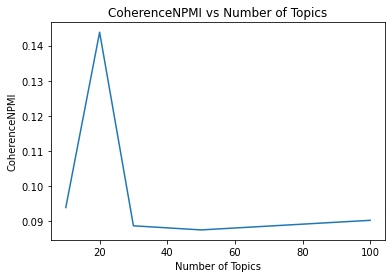

In [44]:
xa1 = np.array([10, 20, 30, 50, 100])
ya1 = np.array([a1, a2, a3, a4, a5])

plt.xlabel('Number of Topics')
plt.ylabel('CoherenceNPMI')

plt.title("CoherenceNPMI vs Number of Topics")

plt.plot(xa1, ya1)
plt.show()

### Plot of train TopicDivergence with Number of Topics

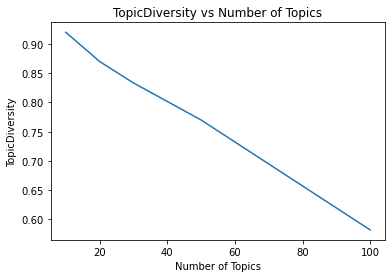

In [45]:
xa2 = np.array([10, 20, 30, 50, 100])
ya2 = np.array([ta1, ta2, ta3, ta4, ta5])

plt.xlabel('Number of Topics')
plt.ylabel('Topic Diversity')

plt.title("Topic Diversity vs Number of Topics")

plt.plot(xa2, ya2)
plt.show()

### Creating a dataframe for train

In [46]:
dict1 = {'Number of Topics' : [10, 20, 30, 50, 100], 
         'CoherenceNPMI' : [a1, a2, a3, a4, a5], 
         'TopicDiversity' : [ta1, ta2, ta3, ta4, ta5]}
df1 = pd.DataFrame(dict1); df1

,Number of Topics,CoherenceNPMI,TopicDiversity
0,10,0.093948,0.920000
1,20,0.143816,0.870000
2,30,0.088750,0.833333
3,50,0.087580,0.770000
4,100,0.090312,0.582000


# Sample of Doc-topic distribution and topic_word distribution for train data

In [47]:
ctma1.get_doc_topic_distribution(training_dataset1, n_samples = 20)

Sampling: [20/20]: : 20it [01:35,  4.76s/it]


array([[0.07440856, 0.11158158, 0.08849872, ..., 0.06725776, 0.02579206,
        0.16898036],
       [0.0385572 , 0.0244658 , 0.07257862, ..., 0.04278131, 0.04818478,
        0.04230366],
       [0.03128867, 0.02741102, 0.15085527, ..., 0.02469015, 0.05743817,
        0.39863479],
       ...,
       [0.03971914, 0.11163411, 0.0514375 , ..., 0.12976189, 0.03641094,
        0.0384683 ],
       [0.10445995, 0.07539652, 0.07671561, ..., 0.21089277, 0.0379296 ,
        0.11556655],
       [0.13209069, 0.08480107, 0.03283284, ..., 0.32592871, 0.02960742,
        0.05113075]])

In [48]:
ctma1.get_doc_topic_distribution(training_dataset1, n_samples = 20).shape

Sampling: [20/20]: : 20it [01:34,  4.71s/it]


(10951, 10)

In [49]:
ctma1.get_topic_lists(k=5)

[['hiv', 'kuwait', 'professor', 'turkish', 'armenian'],
 ['game', 'team', 'ron', 'games', 'st'],
 ['jpeg', 'use', 'edu', 'image', 'file'],
 ['would', 'people', 'attorney', 'think', 'fbi'],
 ['windows', 'card', 'dos', 'drive', 'bus'],
 ['bug', 'option', 'market', 'box', 'friend'],
 ['bug', 'understanding', 'market', 'quickly', 'quick'],
 ['bug', 'option', 'quit', 'understanding', 'market'],
 ['god', 'understanding', 'one', 'christ', 'would'],
 ['market', 'good', 'car', 'would', 'like']]

In [50]:
ctma1.get_topic_word_distribution()

array([[2.06086203e-04, 6.37839839e-05, 2.20522081e-04, ...,
        9.22164763e-04, 1.18520424e-04, 2.81994035e-05],
       [4.83403768e-04, 6.64033287e-04, 2.93314282e-04, ...,
        9.53325594e-04, 2.46334122e-04, 1.08550928e-04],
       [1.37554671e-04, 2.85788294e-04, 4.63483069e-04, ...,
        8.42653899e-05, 3.19525454e-04, 2.32239999e-03],
       ...,
       [2.79491127e-04, 1.43993122e-03, 4.04628686e-09, ...,
        3.72564245e-05, 4.67090402e-04, 2.93805460e-05],
       [1.87142345e-04, 1.16456147e-04, 3.03919049e-04, ...,
        7.08257197e-04, 2.58634245e-04, 5.47981872e-05],
       [3.35446326e-04, 1.38082600e-03, 9.47751163e-04, ...,
        5.71773417e-05, 4.78317641e-04, 3.71709975e-05]], dtype=float32)

In [51]:
ctma1.get_topic_word_distribution().shape

(10, 2000)

In [52]:
ctma1.get_word_distribution_by_topic_id(5)

[('bug', 0.06268149),
 ('option', 0.058349013),
 ('market', 0.058098007),
 ('box', 0.03674876),
 ('friend', 0.0361755),
 ('thanks', 0.02079784),
 ('ndet', 0.020461626),
 ('quick', 0.013456053),
 ('quit', 0.013083618),
 ('location', 0.011435948),
 ('sale', 0.010267222),
 ('advance', 0.0094027035),
 ('email', 0.0068156486),
 ('loop', 0.006689313),
 ('asking', 0.005987933),
 ('looking', 0.005848198),
 ('trade', 0.0054923156),
 ('shape', 0.005477361),
 ('address', 0.004873487),
 ('anybody', 0.0048040776),
 ('reply', 0.004709707),
 ('error', 0.0046646697),
 ('class', 0.0042506037),
 ('interested', 0.004013911),
 ('hi', 0.0039173802),
 ('resolution', 0.0039007459),
 ('shipping', 0.003665235),
 ('appreciated', 0.00365999),
 ('please', 0.0036368833),
 ('offer', 0.0036148014),
 ('via', 0.0035699971),
 ('info', 0.003534892),
 ('included', 0.0034837234),
 ('quickly', 0.0033018256),
 ('excellent', 0.0032938216),
 ('supports', 0.003270889),
 ('hello', 0.0031974707),
 ('include', 0.0031467595),
 ('p

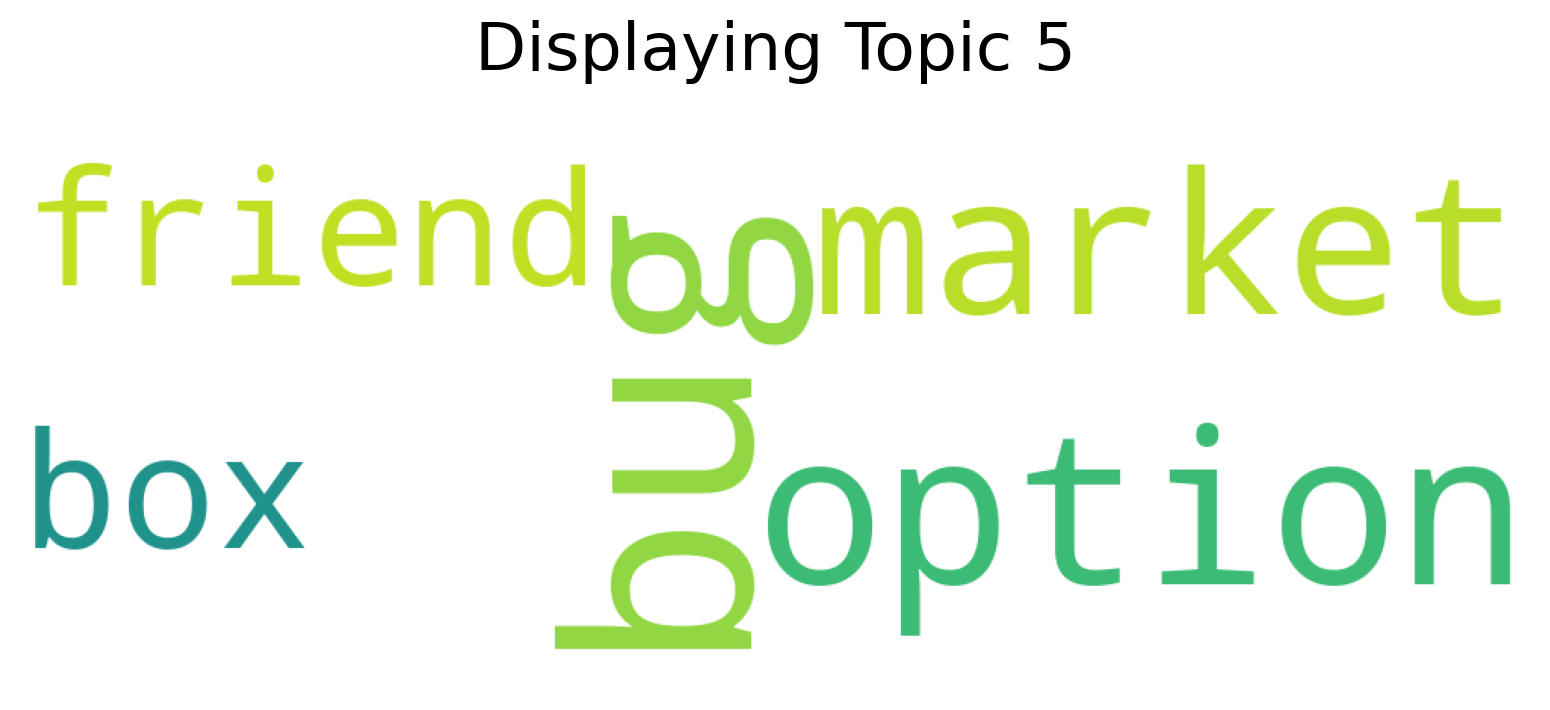

In [53]:
ctma1.get_wordcloud(5, n_words=5, background_color="white", width=1000, height=400)

# 2. Using "stsb-roberta-large" as PLM

In [54]:
tpb = TopicModelDataPreparation("stsb-roberta-large")

# train

In [55]:
training_dataset2 = tpb.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 11765 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
ctmb1 = CombinedTM(bow_size=len(tpb.vocab), contextual_size=1024, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=10, num_epochs=100)
ctmb2 = CombinedTM(bow_size=len(tpb.vocab), contextual_size=1024, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=20, num_epochs=100)
ctmb3 = CombinedTM(bow_size=len(tpb.vocab), contextual_size=1024, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=30, num_epochs=100)
ctmb4 = CombinedTM(bow_size=len(tpb.vocab), contextual_size=1024, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=50, num_epochs=100)
ctmb5 = CombinedTM(bow_size=len(tpb.vocab), contextual_size=1024, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=100, num_epochs=100)

In [57]:
ctmb1.fit(training_dataset2)
ctmb2.fit(training_dataset2)
ctmb3.fit(training_dataset2)
ctmb4.fit(training_dataset2)
ctmb5.fit(training_dataset2)

Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 469.19957541304024	Time: 0:00:13.984277: : 100it [18:37, 11.17s/it]
Sampling: [20/20]: : 20it [01:30,  4.51s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 463.34220654225487	Time: 0:00:13.940097: : 100it [22:32, 13.52s/it]
Sampling: [20/20]: : 20it [01:32,  4.64s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 458.41624035751613	Time: 0:00:07.787808: : 100it [20:10, 12.11s/it]
Sampling: [20/20]: : 20it [00:40,  2.02s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 461.5688240542049	Time: 0:00:07.338673: : 100it [12:22,  7.42s/it]
Sampling: [20/20]: : 20it [00:39,  1.98s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 476.60236385412384	Time: 0:00:07.811149: : 100it [12:54,  7.75s/it]
Sampling: [20/20]: : 20it [00:41,  2.06s/it]


In [58]:
ctmb1.save(models_dir="./")
ctmb2.save(models_dir="./")
ctmb3.save(models_dir="./")
ctmb4.save(models_dir="./")
ctmb5.save(models_dir="./")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNL

# Coherence

In [59]:
npmib1 = CoherenceNPMI(texts=texts, topics=ctmb1.get_topic_lists(10)); b1 = npmib1.score(topk=10)
npmib2 = CoherenceNPMI(texts=texts, topics=ctmb2.get_topic_lists(10)); b2 = npmib2.score(topk=10)
npmib3 = CoherenceNPMI(texts=texts, topics=ctmb3.get_topic_lists(10)); b3 = npmib3.score(topk=10)
npmib4 = CoherenceNPMI(texts=texts, topics=ctmb4.get_topic_lists(10)); b4 = npmib4.score(topk=10)
npmib5 = CoherenceNPMI(texts=texts, topics=ctmb5.get_topic_lists(10)); b5 = npmib5.score(topk=10)

In [60]:
print(f"for 10 topics, the coherenceNPMI is {b1}")
print(f"for 20 topics, the coherenceNPMI is {b2}")
print(f"for 30 topics, the coherenceNPMI is {b3}")
print(f"for 50 topics, the coherenceNPMI is {b4}")
print(f"for 100 topics, the coherenceNPMI is {b5}")

for 10 topics, the coherenceNPMI is 0.13507450943977184
for 20 topics, the coherenceNPMI is 0.11315771216756194
for 30 topics, the coherenceNPMI is 0.11376483362774899
for 50 topics, the coherenceNPMI is 0.0902760506650854
for 100 topics, the coherenceNPMI is 0.11909259288728961


# Diversity

In [61]:
tdb1 = TopicDiversity(topics=ctmb1.get_topic_lists(10)); tb1 = tdb1.score(topk=10)
tdb2 = TopicDiversity(topics=ctmb2.get_topic_lists(10)); tb2 = tdb2.score(topk=10)
tdb3 = TopicDiversity(topics=ctmb3.get_topic_lists(10)); tb3 = tdb3.score(topk=10)
tdb4 = TopicDiversity(topics=ctmb4.get_topic_lists(10)); tb4 = tdb4.score(topk=10)
tdb5 = TopicDiversity(topics=ctmb5.get_topic_lists(10)); tb5 = tdb5.score(topk=10)

In [62]:
print(f"for 10 topics, the TopicDiversity is {tb1}")
print(f"for 20 topics, the TopicDiversity is {tb2}")
print(f"for 30 topics, the TopicDiversity is {tb3}")
print(f"for 50 topics, the TopicDiversity is {tb4}")
print(f"for 100 topics, the TopicDiversity is {tb5}")

for 10 topics, the TopicDiversity is 0.95
for 20 topics, the TopicDiversity is 0.88
for 30 topics, the TopicDiversity is 0.79
for 50 topics, the TopicDiversity is 0.672
for 100 topics, the TopicDiversity is 0.479


# Test Performance

In [63]:
testing_dataset2=tpb.fit(text_for_contextual=unpreprocessed_corpus_test, text_for_bow=preprocessed_documents_test)

ctmb1.fit(testing_dataset2)
ctmb2.fit(testing_dataset2) 
ctmb3.fit(testing_dataset2)
ctmb4.fit(testing_dataset2)
ctmb5.fit(testing_dataset2)

npmib1_test = CoherenceNPMI(texts=texts_test, topics=ctmb1.get_topic_lists(10)); b1_test = npmib1_test.score(topk=10)
npmib2_test = CoherenceNPMI(texts=texts_test, topics=ctmb2.get_topic_lists(10)); b2_test = npmib2_test.score(topk=10)
npmib3_test = CoherenceNPMI(texts=texts_test, topics=ctmb3.get_topic_lists(10)); b3_test = npmib3_test.score(topk=10)
npmib4_test = CoherenceNPMI(texts=texts_test, topics=ctmb4.get_topic_lists(10)); b4_test = npmib4_test.score(topk=10)
npmib5_test = CoherenceNPMI(texts=texts_test, topics=ctmb5.get_topic_lists(10)); b5_test = npmib5_test.score(topk=10)

print(f"for 10 topics, the coherenceNPMI is {b1_test}")
print(f"for 20 topics, the coherenceNPMI is {b2_test}")
print(f"for 30 topics, the coherenceNPMI is {b3_test}")
print(f"for 50 topics, the coherenceNPMI is {b4_test}")
print(f"for 100 topics, the coherenceNPMI is {b5_test}")

tdb1_test = TopicDiversity(topics=ctmb1.get_topic_lists(10)); tb1_test = tdb1_test.score(topk=10)
tdb2_test = TopicDiversity(topics=ctmb2.get_topic_lists(10)); tb2_test = tdb2_test.score(topk=10)
tdb3_test = TopicDiversity(topics=ctmb3.get_topic_lists(10)); tb3_test = tdb3_test.score(topk=10)
tdb4_test = TopicDiversity(topics=ctmb4.get_topic_lists(10)); tb4_test = tdb4_test.score(topk=10)
tdb5_test = TopicDiversity(topics=ctmb5.get_topic_lists(10)); tb5_test = tdb5_test.score(topk=10)

print(f"for 10 topics, the TopicDiversity is {tb1_test}")
print(f"for 20 topics, the TopicDiversity is {tb2_test}")
print(f"for 30 topics, the TopicDiversity is {tb3_test}")
print(f"for 50 topics, the TopicDiversity is {tb4_test}")
print(f"for 100 topics, the TopicDiversity is {tb5_test}")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 9507 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 423.2370965764386	Time: 0:00:04.950486: : 100it [08:21,  5.02s/it]
Sampling: [20/20]: : 20it [00:29,  1.48s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 420.9559285840274	Time: 0:00:05.043370: : 100it [08:25,  5.05s/it]
Sampling: [20/20]: : 20it [00:32,  1.63s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 422.40461273865554	Time: 0:00:05.063012: : 100it [08:28,  5.08s/it]
Sampling: [20/20]: : 20it [00:32,  1.64s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 427.0021565979273	Time: 0:00:05.247055: : 100it [08:41,  5.22s/it]
Sampling: [20/20]: : 20it [00:30,  1.52s/it]
Epoch: [100/100]

for 10 topics, the coherenceNPMI is 0.014022843967265181
for 20 topics, the coherenceNPMI is 0.06976623736940395
for 30 topics, the coherenceNPMI is 0.05359577595561638
for 50 topics, the coherenceNPMI is 0.06516649142110481
for 100 topics, the coherenceNPMI is 0.056172406589577645
for 10 topics, the TopicDiversity is 0.88
for 20 topics, the TopicDiversity is 0.91
for 30 topics, the TopicDiversity is 0.8366666666666667
for 50 topics, the TopicDiversity is 0.722
for 100 topics, the TopicDiversity is 0.479


# Plot for Train

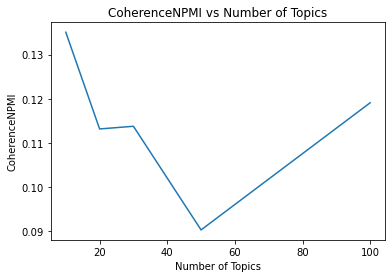

In [64]:
xb1 = np.array([10, 20, 30, 50, 100])
yb1 = np.array([b1, b2, b3, b4, b5])

plt.xlabel('Number of Topics')
plt.ylabel('CoherenceNPMI')

plt.title("CoherenceNPMI vs Number of Topics")

plt.plot(xb1, yb1)
plt.show()

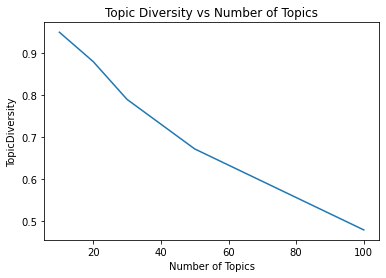

In [65]:
xb2 = np.array([10, 20, 30, 50, 100])
yb2 = np.array([tb1, tb2, tb3, tb4, tb5])

plt.xlabel('Number of Topics')
plt.ylabel('TopicDiversity')

plt.title("Topic Diversity vs Number of Topics")

plt.plot(xb2, yb2)
plt.show()

In [66]:
dict2 = {'Number of Topics' : [10, 20, 30, 50, 100], 
         'CoherenceNPMI' : [b1, b2, b3, b4, b5], 
         'TopicDiversity' : [tb1, tb2, tb3, tb4, tb5]}
df2 = pd.DataFrame(dict2); df2

,Number of Topics,CoherenceNPMI,TopicDiversity
0,10,0.135075,0.950
1,20,0.113158,0.880
2,30,0.113765,0.790
3,50,0.090276,0.672
4,100,0.119093,0.479


# 3. Using "bert-base-nli-mean-tokens" as PLM

In [67]:
tpc = TopicModelDataPreparation("bert-base-nli-mean-tokens")

In [68]:
training_dataset3=tpc.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 11765 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [69]:
ctmc1 = CombinedTM(bow_size=len(tpc.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=10, num_epochs=100)
ctmc2 = CombinedTM(bow_size=len(tpc.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=20, num_epochs=100)
ctmc3 = CombinedTM(bow_size=len(tpc.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=30, num_epochs=100)
ctmc4 = CombinedTM(bow_size=len(tpc.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=50, num_epochs=100)
ctmc5 = CombinedTM(bow_size=len(tpc.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=100, num_epochs=100)

In [70]:
ctmc1.fit(training_dataset3)
ctmc2.fit(training_dataset3)
ctmc3.fit(training_dataset3)
ctmc4.fit(training_dataset3)
ctmc5.fit(training_dataset3)

Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 467.13941598635665	Time: 0:00:06.153602: : 100it [09:53,  5.93s/it]
Sampling: [20/20]: : 20it [00:33,  1.66s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 457.2665548045733	Time: 0:00:05.912193: : 100it [09:58,  5.98s/it]
Sampling: [20/20]: : 20it [00:33,  1.67s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 455.31866593388787	Time: 0:00:06.274658: : 100it [10:36,  6.37s/it]
Sampling: [20/20]: : 20it [00:35,  1.78s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 459.93027460644817	Time: 0:00:06.265038: : 100it [10:26,  6.26s/it]
Sampling: [20/20]: : 20it [00:35,  1.79s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 477.37565568176626	Time: 0:00:06.655711: : 100it [11:00,  6.61s/it]
Sampling: [20/20]: : 20it [00:37,  1.88s/it]


In [71]:
ctmc1.save(models_dir="./")
ctmc2.save(models_dir="./")
ctmc3.save(models_dir="./")
ctmc4.save(models_dir="./")
ctmc5.save(models_dir="./")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNL

# Train Performance

In [72]:
npmic1 = CoherenceNPMI(texts=texts, topics=ctmc1.get_topic_lists(10)); c1 = npmic1.score(topk=10)
npmic2 = CoherenceNPMI(texts=texts, topics=ctmc2.get_topic_lists(10)); c2 = npmic2.score(topk=10)
npmic3 = CoherenceNPMI(texts=texts, topics=ctmc3.get_topic_lists(10)); c3 = npmic3.score(topk=10)
npmic4 = CoherenceNPMI(texts=texts, topics=ctmc4.get_topic_lists(10)); c4 = npmic4.score(topk=10)
npmic5 = CoherenceNPMI(texts=texts, topics=ctmc5.get_topic_lists(10)); c5 = npmic5.score(topk=10)

In [73]:
print(f"for 10 topics, the coherenceNPMI is {c1}")
print(f"for 20 topics, the coherenceNPMI is {c2}")
print(f"for 30 topics, the coherenceNPMI is {c3}")
print(f"for 50 topics, the coherenceNPMI is {c4}")
print(f"for 100 topics, the coherenceNPMI is {c5}")

for 10 topics, the coherenceNPMI is 0.16341945875135283
for 20 topics, the coherenceNPMI is 0.14529102723548162
for 30 topics, the coherenceNPMI is 0.11060492543598659
for 50 topics, the coherenceNPMI is 0.09297755881015819
for 100 topics, the coherenceNPMI is 0.11668193679201788


In [74]:
tdc1 = TopicDiversity(topics=ctmc1.get_topic_lists(10)); tc1 = tdc1.score(topk=10)
tdc2 = TopicDiversity(topics=ctmc2.get_topic_lists(10)); tc2 = tdc2.score(topk=10)
tdc3 = TopicDiversity(topics=ctmc3.get_topic_lists(10)); tc3 = tdc3.score(topk=10)
tdc4 = TopicDiversity(topics=ctmc4.get_topic_lists(10)); tc4 = tdc4.score(topk=10)
tdc5 = TopicDiversity(topics=ctmc5.get_topic_lists(10)); tc5 = tdc5.score(topk=10)

In [75]:
print(f"for 10 topics, the TopicDiversity is {tc1}")
print(f"for 20 topics, the TopicDiversity is {tc2}")
print(f"for 30 topics, the TopicDiversity is {tc3}")
print(f"for 50 topics, the TopicDiversity is {tc4}")
print(f"for 100 topics, the TopicDiversity is {tc5}")

for 10 topics, the TopicDiversity is 0.96
for 20 topics, the TopicDiversity is 0.85
for 30 topics, the TopicDiversity is 0.7933333333333333
for 50 topics, the TopicDiversity is 0.71
for 100 topics, the TopicDiversity is 0.475


# Test Performance

In [76]:
testing_dataset3=tpc.fit(text_for_contextual=unpreprocessed_corpus_test, text_for_bow=preprocessed_documents_test)

ctmc1.fit(testing_dataset3)
ctmc2.fit(testing_dataset3) 
ctmc3.fit(testing_dataset3)
ctmc4.fit(testing_dataset3)
ctmc5.fit(testing_dataset3)

npmic1_test = CoherenceNPMI(texts=texts_test, topics=ctmc1.get_topic_lists(10)); c1_test = npmic1_test.score(topk=10)
npmic2_test = CoherenceNPMI(texts=texts_test, topics=ctmc2.get_topic_lists(10)); c2_test = npmic2_test.score(topk=10)
npmic3_test = CoherenceNPMI(texts=texts_test, topics=ctmc3.get_topic_lists(10)); c3_test = npmic3_test.score(topk=10)
npmic4_test = CoherenceNPMI(texts=texts_test, topics=ctmc4.get_topic_lists(10)); c4_test = npmic4_test.score(topk=10)
npmic5_test = CoherenceNPMI(texts=texts_test, topics=ctmc5.get_topic_lists(10)); c5_test = npmic5_test.score(topk=10)

print(f"for 10 topics, the coherenceNPMI is {c1_test}")
print(f"for 20 topics, the coherenceNPMI is {c2_test}")
print(f"for 30 topics, the coherenceNPMI is {c3_test}")
print(f"for 50 topics, the coherenceNPMI is {c4_test}")
print(f"for 100 topics, the coherenceNPMI is {c5_test}")

tdc1_test = TopicDiversity(topics=ctmc1.get_topic_lists(10)); tc1_test = tdc1_test.score(topk=10)
tdc2_test = TopicDiversity(topics=ctmc2.get_topic_lists(10)); tc2_test = tdc2_test.score(topk=10)
tdc3_test = TopicDiversity(topics=ctmc3.get_topic_lists(10)); tc3_test = tdc3_test.score(topk=10)
tdc4_test = TopicDiversity(topics=ctmc4.get_topic_lists(10)); tc4_test = tdc4_test.score(topk=10)
tdc5_test = TopicDiversity(topics=ctmc5.get_topic_lists(10)); tc5_test = tdc5_test.score(topk=10)

print(f"for 10 topics, the TopicDiversity is {tc1_test}")
print(f"for 20 topics, the TopicDiversity is {tc2_test}")
print(f"for 30 topics, the TopicDiversity is {tc3_test}")
print(f"for 50 topics, the TopicDiversity is {tc4_test}")
print(f"for 100 topics, the TopicDiversity is {tc5_test}")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 9507 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 423.00105352863864	Time: 0:00:04.464214: : 100it [07:32,  4.52s/it]
Sampling: [20/20]: : 20it [00:26,  1.34s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 420.23877766478955	Time: 0:00:04.366490: : 100it [07:16,  4.36s/it]
Sampling: [20/20]: : 20it [00:28,  1.41s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 422.8354381275597	Time: 0:00:04.488551: : 100it [07:25,  4.46s/it]
Sampling: [20/20]: : 20it [00:28,  1.45s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 427.4842462749733	Time: 0:00:04.621960: : 100it [07:28,  4.48s/it]
Sampling: [20/20]: : 20it [00:28,  1.45s/it]
Epoch: [100/100

for 10 topics, the coherenceNPMI is 0.012100127138184494
for 20 topics, the coherenceNPMI is 0.014712533629366906
for 30 topics, the coherenceNPMI is 0.09828489152397285
for 50 topics, the coherenceNPMI is 0.07836029267526741
for 100 topics, the coherenceNPMI is 0.0652919971008017
for 10 topics, the TopicDiversity is 0.89
for 20 topics, the TopicDiversity is 0.885
for 30 topics, the TopicDiversity is 0.87
for 50 topics, the TopicDiversity is 0.714
for 100 topics, the TopicDiversity is 0.514


# Plot Train performance

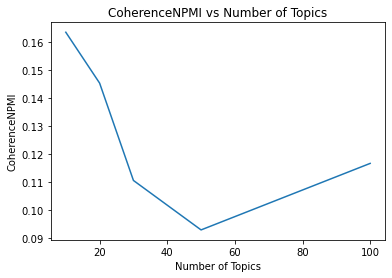

In [77]:
xc1 = np.array([10, 20, 30, 50, 100])
yc1 = np.array([c1, c2, c3, c4, c5])

plt.xlabel('Number of Topics')
plt.ylabel('CoherenceNPMI')

plt.title("CoherenceNPMI vs Number of Topics")

plt.plot(xc1, yc1)
plt.show()

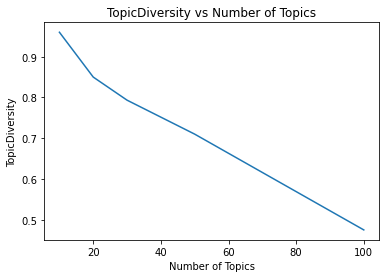

In [78]:
xc2 = np.array([10, 20, 30, 50, 100])
yc2 = np.array([tc1, tc2, tc3, tc4, tc5])

plt.xlabel('Number of Topics')
plt.ylabel('TopicDiversity')

plt.title("TopicDiversity vs Number of Topics")

plt.plot(xc2, yc2)
plt.show()

In [79]:
dict3 = {'Number of Topics' : [10, 20, 30, 50, 100], 
         'CoherenceNPMI' : [c1, c2, c3, c4, c5], 
         'TopicDiversity' : [tc1, tc2, tc3, tc4, tc5]}
df3 = pd.DataFrame(dict3); df3

,Number of Topics,CoherenceNPMI,TopicDiversity
0,10,0.163419,0.960000
1,20,0.145291,0.850000
2,30,0.110605,0.793333
3,50,0.092978,0.710000
4,100,0.116682,0.475000


# 4. Using "all-distilroberta-v1" as PLM

In [80]:
tpd = TopicModelDataPreparation("all-distilroberta-v1")

In [81]:
training_dataset4=tpd.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 11765 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
ctmd1 = CombinedTM(bow_size=len(tpd.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=10, num_epochs=100)
ctmd2 = CombinedTM(bow_size=len(tpd.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=20, num_epochs=100)
ctmd3 = CombinedTM(bow_size=len(tpd.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=30, num_epochs=100)
ctmd4 = CombinedTM(bow_size=len(tpd.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=50, num_epochs=100)
ctmd5 = CombinedTM(bow_size=len(tpd.vocab), contextual_size=768, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=100, num_epochs=100)

In [83]:
ctmd1.fit(training_dataset4)
ctmd2.fit(training_dataset4)
ctmd3.fit(training_dataset4)
ctmd4.fit(training_dataset4)
ctmd5.fit(training_dataset4)

Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 470.36755812795536	Time: 0:00:05.825925: : 100it [10:03,  6.03s/it]
Sampling: [20/20]: : 20it [00:34,  1.71s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 451.09170233297067	Time: 0:00:06.108334: : 100it [10:04,  6.04s/it]
Sampling: [20/20]: : 20it [00:36,  1.83s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 454.1977777313768	Time: 0:00:06.123322: : 100it [10:05,  6.06s/it]
Sampling: [20/20]: : 20it [00:36,  1.80s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 455.63475527400857	Time: 0:00:06.220213: : 100it [10:17,  6.18s/it]
Sampling: [20/20]: : 20it [00:37,  1.87s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 471.6491935239201	Time: 0:00:06.530818: : 100it [10:59,  6.59s/it]
Sampling: [20/20]: : 20it [00:38,  1.90s/it]


In [84]:
ctmd1.save(models_dir="./")
ctmd2.save(models_dir="./")
ctmd3.save(models_dir="./")
ctmd4.save(models_dir="./")
ctmd5.save(models_dir="./")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNL

# Train Performance

In [85]:
npmid1 = CoherenceNPMI(texts=texts, topics=ctmd1.get_topic_lists(10)); d1 = npmid1.score(topk=10)
npmid2 = CoherenceNPMI(texts=texts, topics=ctmd2.get_topic_lists(10)); d2 = npmid2.score(topk=10)
npmid3 = CoherenceNPMI(texts=texts, topics=ctmd3.get_topic_lists(10)); d3 = npmid3.score(topk=10)
npmid4 = CoherenceNPMI(texts=texts, topics=ctmd4.get_topic_lists(10)); d4 = npmid4.score(topk=10)
npmid5 = CoherenceNPMI(texts=texts, topics=ctmd5.get_topic_lists(10)); d5 = npmid5.score(topk=10)

In [86]:
print(f"for 10 topics, the coherenceNPMI is {d1}")
print(f"for 20 topics, the coherenceNPMI is {d2}")
print(f"for 30 topics, the coherenceNPMI is {d3}")
print(f"for 50 topics, the coherenceNPMI is {d4}")
print(f"for 100 topics, the coherenceNPMI is {d5}")

for 10 topics, the coherenceNPMI is 0.15480508391156195
for 20 topics, the coherenceNPMI is 0.149604878550326
for 30 topics, the coherenceNPMI is 0.14347110629529822
for 50 topics, the coherenceNPMI is 0.09410966027391238
for 100 topics, the coherenceNPMI is 0.0874957730405089


In [87]:
tdd1 = TopicDiversity(topics=ctmd1.get_topic_lists(10)); td1 = tdd1.score(topk=10)
tdd2 = TopicDiversity(topics=ctmd2.get_topic_lists(10)); td2 = tdd2.score(topk=10)
tdd3 = TopicDiversity(topics=ctmd3.get_topic_lists(10)); td3 = tdd3.score(topk=10)
tdd4 = TopicDiversity(topics=ctmd4.get_topic_lists(10)); td4 = tdd4.score(topk=10)
tdd5 = TopicDiversity(topics=ctmd5.get_topic_lists(10)); td5 = tdd5.score(topk=10)

In [88]:
print(f"for 10 topics, the TopicDiversity is {td1}")
print(f"for 20 topics, the TopicDiversity is {td2}")
print(f"for 30 topics, the TopicDiversity is {td3}")
print(f"for 50 topics, the TopicDiversity is {td4}")
print(f"for 100 topics, the TopicDiversity is {td5}")

for 10 topics, the TopicDiversity is 0.92
for 20 topics, the TopicDiversity is 0.86
for 30 topics, the TopicDiversity is 0.8266666666666667
for 50 topics, the TopicDiversity is 0.764
for 100 topics, the TopicDiversity is 0.576


# Test Performance

In [89]:
testing_dataset4=tpd.fit(text_for_contextual=unpreprocessed_corpus_test, text_for_bow=preprocessed_documents_test)

ctmd1.fit(testing_dataset4)
ctmd2.fit(testing_dataset4) 
ctmd3.fit(testing_dataset4)
ctmd4.fit(testing_dataset4)
ctmd5.fit(testing_dataset4)

npmid1_test = CoherenceNPMI(texts=texts_test, topics=ctmd1.get_topic_lists(10)); d1_test = npmid1_test.score(topk=10)
npmid2_test = CoherenceNPMI(texts=texts_test, topics=ctmd2.get_topic_lists(10)); d2_test = npmid2_test.score(topk=10)
npmid3_test = CoherenceNPMI(texts=texts_test, topics=ctmd3.get_topic_lists(10)); d3_test = npmid3_test.score(topk=10)
npmid4_test = CoherenceNPMI(texts=texts_test, topics=ctmd4.get_topic_lists(10)); d4_test = npmid4_test.score(topk=10)
npmid5_test = CoherenceNPMI(texts=texts_test, topics=ctmd5.get_topic_lists(10)); d5_test = npmid5_test.score(topk=10)

print(f"for 10 topics, the coherenceNPMI is {d1_test}")
print(f"for 20 topics, the coherenceNPMI is {d2_test}")
print(f"for 30 topics, the coherenceNPMI is {d3_test}")
print(f"for 50 topics, the coherenceNPMI is {d4_test}")
print(f"for 100 topics, the coherenceNPMI is {d5_test}")

tdd1_test = TopicDiversity(topics=ctmd1.get_topic_lists(10)); td1_test = tdd1_test.score(topk=10)
tdd2_test = TopicDiversity(topics=ctmd2.get_topic_lists(10)); td2_test = tdd2_test.score(topk=10)
tdd3_test = TopicDiversity(topics=ctmd3.get_topic_lists(10)); td3_test = tdd3_test.score(topk=10)
tdd4_test = TopicDiversity(topics=ctmd4.get_topic_lists(10)); td4_test = tdd4_test.score(topk=10)
tdd5_test = TopicDiversity(topics=ctmd5.get_topic_lists(10)); td5_test = tdd5_test.score(topk=10)

print(f"for 10 topics, the TopicDiversity is {td1_test}")
print(f"for 20 topics, the TopicDiversity is {td2_test}")
print(f"for 30 topics, the TopicDiversity is {td3_test}")
print(f"for 50 topics, the TopicDiversity is {td4_test}")
print(f"for 100 topics, the TopicDiversity is {td5_test}")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 9507 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 422.46035329675885	Time: 0:00:04.534031: : 100it [07:21,  4.41s/it]
Sampling: [20/20]: : 20it [00:29,  1.46s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 419.50929811452454	Time: 0:00:04.257697: : 100it [07:21,  4.41s/it]
Sampling: [20/20]: : 20it [00:29,  1.48s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 420.3007710326611	Time: 0:00:04.383260: : 100it [07:36,  4.56s/it]
Sampling: [20/20]: : 20it [00:30,  1.51s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 424.3382917227724	Time: 0:00:04.642600: : 100it [07:47,  4.67s/it]
Sampling: [20/20]: : 20it [00:31,  1.56s/it]
Epoch: [100/100

for 10 topics, the coherenceNPMI is -0.022130164107361343
for 20 topics, the coherenceNPMI is 0.07113830235637274
for 30 topics, the coherenceNPMI is 0.045385015525804207
for 50 topics, the coherenceNPMI is 0.05484881081053179
for 100 topics, the coherenceNPMI is 0.03634190885728875
for 10 topics, the TopicDiversity is 0.87
for 20 topics, the TopicDiversity is 0.895
for 30 topics, the TopicDiversity is 0.8666666666666667
for 50 topics, the TopicDiversity is 0.79
for 100 topics, the TopicDiversity is 0.568


# Train Plot

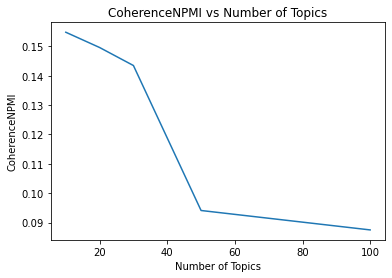

In [90]:
xd1 = np.array([10, 20, 30, 50, 100])
yd1 = np.array([d1, d2, d3, d4, d5])

plt.xlabel('Number of Topics')
plt.ylabel('CoherenceNPMI')

plt.title("CoherenceNPMI vs Number of Topics")

plt.plot(xd1, yd1)
plt.show()

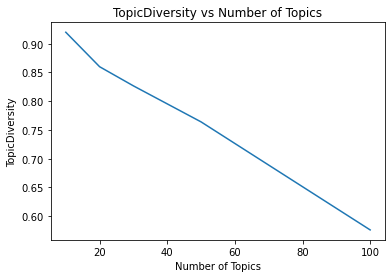

In [91]:
xd2 = np.array([10, 20, 30, 50, 100])
yd2 = np.array([td1, td2, td3, td4, td5])

plt.xlabel('Number of Topics')
plt.ylabel('TopicDiversity')

plt.title("TopicDiversity vs Number of Topics")

plt.plot(xd2, yd2)
plt.show()

In [92]:
dict4 = {'Number of Topics' : [10, 20, 30, 50, 100], 
         'CoherenceNPMI' : [d1, d2, d3, d4, d5], 
         'TopicDiversity' : [td1, td2, td3, td4, td5]}
df4 = pd.DataFrame(dict4); df4

,Number of Topics,CoherenceNPMI,TopicDiversity
0,10,0.154805,0.920000
1,20,0.149605,0.860000
2,30,0.143471,0.826667
3,50,0.094110,0.764000
4,100,0.087496,0.576000


# 5. Using "all-MiniLM-L6-v2 " as PLM

In [93]:
tpe = TopicModelDataPreparation("all-MiniLM-L6-v2")

In [94]:
training_dataset5=tpe.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 11765 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
ctme1 = CombinedTM(bow_size=len(tpe.vocab), contextual_size=384, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=10, num_epochs=100)
ctme2 = CombinedTM(bow_size=len(tpe.vocab), contextual_size=384, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=20, num_epochs=100)
ctme3 = CombinedTM(bow_size=len(tpe.vocab), contextual_size=384, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=30, num_epochs=100)
ctme4 = CombinedTM(bow_size=len(tpe.vocab), contextual_size=384, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=50, num_epochs=100)
ctme5 = CombinedTM(bow_size=len(tpe.vocab), contextual_size=384, model_type='prodLDA',
                 dropout=0.2, batch_size=32, lr=0.01, solver='adam',
                 n_components=100, num_epochs=100)

In [96]:
ctme1.fit(training_dataset5)
ctme2.fit(training_dataset5)
ctme3.fit(training_dataset5)
ctme4.fit(training_dataset5)
ctme5.fit(training_dataset5)

Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 464.8095235991896	Time: 0:00:04.336275: : 100it [07:05,  4.26s/it]
Sampling: [20/20]: : 20it [00:34,  1.74s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 457.1333846599735	Time: 0:00:04.603106: : 100it [07:13,  4.34s/it]
Sampling: [20/20]: : 20it [00:34,  1.71s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 465.67386533502946	Time: 0:00:04.257886: : 100it [07:06,  4.27s/it]
Sampling: [20/20]: : 20it [00:35,  1.75s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 457.3337213616622	Time: 0:00:04.311345: : 100it [07:08,  4.29s/it]
Sampling: [20/20]: : 20it [00:34,  1.74s/it]
Epoch: [100/100]	 Seen Samples: [1094400/1095100]	Train Loss: 469.83865401061655	Time: 0:00:04.394441: : 100it [07:30,  4.50s/it]
Sampling: [20/20]: : 20it [00:34,  1.74s/it]


In [97]:
ctme1.save(models_dir="./")
ctme2.save(models_dir="./")
ctme3.save(models_dir="./")
ctme4.save(models_dir="./")
ctme5.save(models_dir="./")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn("This is an experimental feature that we has not been fully tested. Refer to the following issue:"
/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/models/ctm.py:473: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNL

# Train Performance

In [98]:
npmie1 = CoherenceNPMI(texts=texts, topics=ctme1.get_topic_lists(10)); e1 = npmie1.score(topk=10)
npmie2 = CoherenceNPMI(texts=texts, topics=ctme2.get_topic_lists(10)); e2 = npmie2.score(topk=10)
npmie3 = CoherenceNPMI(texts=texts, topics=ctme3.get_topic_lists(10)); e3 = npmie3.score(topk=10)
npmie4 = CoherenceNPMI(texts=texts, topics=ctme4.get_topic_lists(10)); e4 = npmie4.score(topk=10)
npmie5 = CoherenceNPMI(texts=texts, topics=ctme5.get_topic_lists(10)); e5 = npmie5.score(topk=10)

In [99]:
print(f"for 10 topics, the coherenceNPMI is {e1}")
print(f"for 20 topics, the coherenceNPMI is {e2}")
print(f"for 30 topics, the coherenceNPMI is {e3}")
print(f"for 50 topics, the coherenceNPMI is {e4}")
print(f"for 100 topics, the coherenceNPMI is {e5}")

for 10 topics, the coherenceNPMI is 0.14183178092611065
for 20 topics, the coherenceNPMI is 0.10196442736598603
for 30 topics, the coherenceNPMI is 0.049072064041747146
for 50 topics, the coherenceNPMI is 0.10826772742831575
for 100 topics, the coherenceNPMI is 0.08160272253857466


In [100]:
tde1 = TopicDiversity(topics=ctme1.get_topic_lists(10)); te1 = tde1.score(topk=10)
tde2 = TopicDiversity(topics=ctme2.get_topic_lists(10)); te2 = tde2.score(topk=10)
tde3 = TopicDiversity(topics=ctme3.get_topic_lists(10)); te3 = tde3.score(topk=10)
tde4 = TopicDiversity(topics=ctme4.get_topic_lists(10)); te4 = tde4.score(topk=10)
tde5 = TopicDiversity(topics=ctme5.get_topic_lists(10)); te5 = tde5.score(topk=10)

In [101]:
print(f"for 10 topics, the TopicDiversity is {te1}")
print(f"for 20 topics, the TopicDiversity is {te2}")
print(f"for 30 topics, the TopicDiversity is {te3}")
print(f"for 50 topics, the TopicDiversity is {te4}")
print(f"for 100 topics, the TopicDiversity is {te5}")

for 10 topics, the TopicDiversity is 0.91
for 20 topics, the TopicDiversity is 0.88
for 30 topics, the TopicDiversity is 0.8
for 50 topics, the TopicDiversity is 0.758
for 100 topics, the TopicDiversity is 0.59


# Test Performance

In [103]:
testing_dataset5=tpe.fit(text_for_contextual=unpreprocessed_corpus_test, text_for_bow=preprocessed_documents_test)

ctme1.fit(testing_dataset5)
ctme2.fit(testing_dataset5) 
ctme3.fit(testing_dataset5)
ctme4.fit(testing_dataset5)
ctme5.fit(testing_dataset5)

npmie1_test = CoherenceNPMI(texts=texts_test, topics=ctme1.get_topic_lists(10)); e1_test = npmie1_test.score(topk=10)
npmie2_test = CoherenceNPMI(texts=texts_test, topics=ctme2.get_topic_lists(10)); e2_test = npmie2_test.score(topk=10)
npmie3_test = CoherenceNPMI(texts=texts_test, topics=ctme3.get_topic_lists(10)); e3_test = npmie3_test.score(topk=10)
npmie4_test = CoherenceNPMI(texts=texts_test, topics=ctme4.get_topic_lists(10)); e4_test = npmie4_test.score(topk=10)
npmie5_test = CoherenceNPMI(texts=texts_test, topics=ctme5.get_topic_lists(10)); e5_test = npmie5_test.score(topk=10)

print(f"for 10 topics, the coherenceNPMI is {e1_test}")
print(f"for 20 topics, the coherenceNPMI is {e2_test}")
print(f"for 30 topics, the coherenceNPMI is {e3_test}")
print(f"for 50 topics, the coherenceNPMI is {e4_test}")
print(f"for 100 topics, the coherenceNPMI is {e5_test}")

tde1_test = TopicDiversity(topics=ctme1.get_topic_lists(10)); te1_test = tdd1_test.score(topk=10)
tde2_test = TopicDiversity(topics=ctme2.get_topic_lists(10)); te2_test = tdd2_test.score(topk=10)
tde3_test = TopicDiversity(topics=ctme3.get_topic_lists(10)); te3_test = tdd3_test.score(topk=10)
tde4_test = TopicDiversity(topics=ctme4.get_topic_lists(10)); te4_test = tdd4_test.score(topk=10)
tde5_test = TopicDiversity(topics=ctme5.get_topic_lists(10)); te5_test = tdd5_test.score(topk=10)

print(f"for 10 topics, the TopicDiversity is {te1_test}")
print(f"for 20 topics, the TopicDiversity is {te2_test}")
print(f"for 30 topics, the TopicDiversity is {te3_test}")
print(f"for 50 topics, the TopicDiversity is {te4_test}")
print(f"for 100 topics, the TopicDiversity is {te5_test}")

/home/sysadm/anaconda3/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 9507 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

/home/sysadm/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 421.79572581824755	Time: 0:00:03.261025: : 100it [05:21,  3.22s/it]
Sampling: [20/20]: : 20it [00:28,  1.43s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 419.6244254763431	Time: 0:00:03.262560: : 100it [05:25,  3.26s/it]
Sampling: [20/20]: : 20it [00:29,  1.49s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 419.61933636770374	Time: 0:00:03.359234: : 100it [05:37,  3.37s/it]
Sampling: [20/20]: : 20it [00:29,  1.48s/it]
Epoch: [100/100]	 Seen Samples: [726400/726700]	Train Loss: 422.98454674540113	Time: 0:00:03.450390: : 100it [05:40,  3.40s/it]
Sampling: [20/20]: : 20it [00:29,  1.50s/it]
Epoch: [100/10

for 10 topics, the coherenceNPMI is -0.03342547801201699
for 20 topics, the coherenceNPMI is 0.048447744510257885
for 30 topics, the coherenceNPMI is 0.06498893493921098
for 50 topics, the coherenceNPMI is 0.059695528166389594
for 100 topics, the coherenceNPMI is 0.023282640717663207
for 10 topics, the TopicDiversity is 0.87
for 20 topics, the TopicDiversity is 0.895
for 30 topics, the TopicDiversity is 0.8666666666666667
for 50 topics, the TopicDiversity is 0.79
for 100 topics, the TopicDiversity is 0.568


# Train Plot

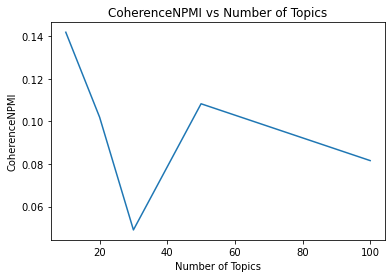

In [104]:
xe1 = np.array([10, 20, 30, 50, 100])
ye1 = np.array([e1, e2, e3, e4, e5])

plt.xlabel('Number of Topics')
plt.ylabel('CoherenceNPMI')

plt.title("CoherenceNPMI vs Number of Topics")

plt.plot(xe1, ye1)
plt.show()

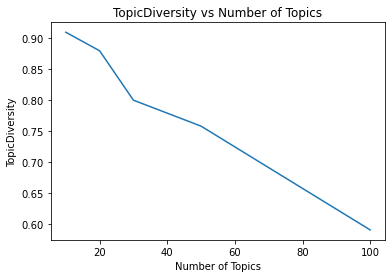

In [105]:
xe2 = np.array([10, 20, 30, 50, 100])
ye2 = np.array([te1, te2, te3, te4, te5])

plt.xlabel('Number of Topics')
plt.ylabel('TopicDiversity')

plt.title("TopicDiversity vs Number of Topics")

plt.plot(xe2, ye2)
plt.show()

In [106]:
dict5 = {'Number of Topics' : [10, 20, 30, 50, 100], 
         'CoherenceNPMI' : [e1, e2, e3, e4, e5], 
         'TopicDiversity' : [te1, te2, te3, te4, te5]}
df5 = pd.DataFrame(dict5); df5

,Number of Topics,CoherenceNPMI,TopicDiversity
0,10,0.141832,0.910
1,20,0.101964,0.880
2,30,0.049072,0.800
3,50,0.108268,0.758
4,100,0.081603,0.590


# Component wise coherence for 5 PLMs for train

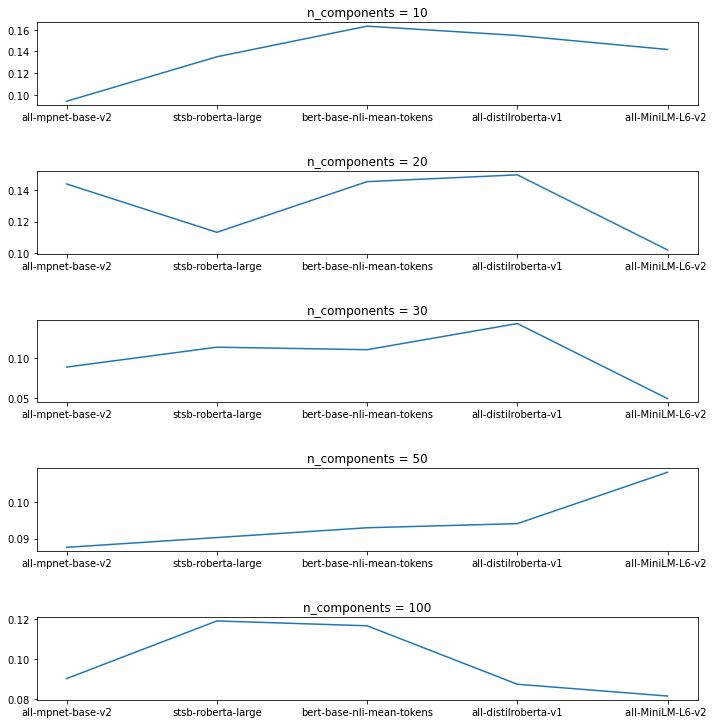

In [107]:
X = ['all-mpnet-base-v2', 'stsb-roberta-large', 
      'bert-base-nli-mean-tokens', 'all-distilroberta-v1', 'all-MiniLM-L6-v2 ']


Y1 = [a1, b1, c1, d1, e1]
Y2 = [a2, b2, c2, d2, e2]
Y3 = [a3, b3, c3, d3, e3]
Y4 = [a4, b4, c4, d4, e4]
Y5 = [a5, b5, c5, d5, e5]

figure, axis = plt.subplots(5, 1, figsize = (10,10))
figure.tight_layout()

axis[0].plot(X, Y1)
axis[0].set_title("n_components = 10")

axis[1].plot(X, Y2)
axis[1].set_title("n_components = 20")

axis[2].plot(X, Y3)
axis[2].set_title("n_components = 30")

axis[3].plot(X, Y4)
axis[3].set_title("n_components = 50")
                     
axis[4].plot(X, Y5)
axis[4].set_title("n_components = 100")   

plt.subplots_adjust(hspace=0.8)

plt.show()

# Component wise TopicDiversity for 5 PLMs for Train

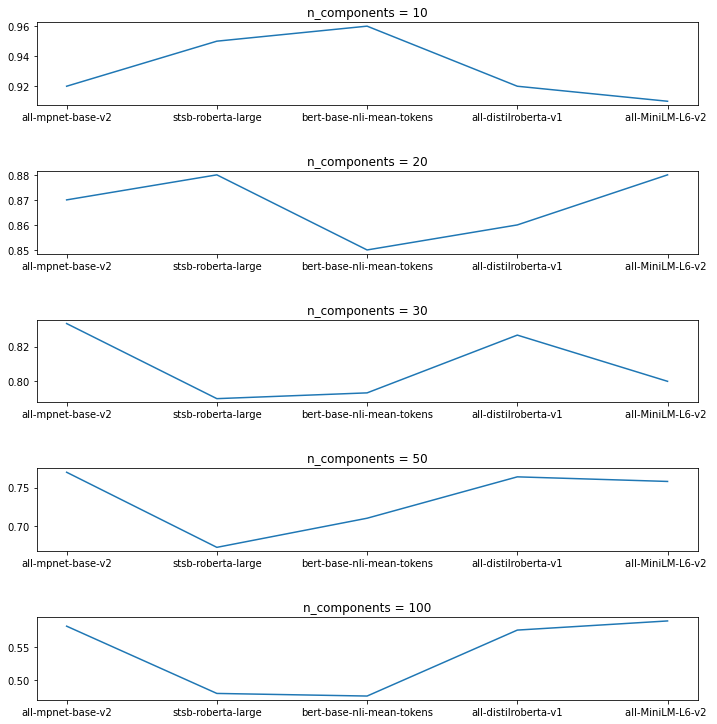

In [108]:
X = ['all-mpnet-base-v2', 'stsb-roberta-large', 
      'bert-base-nli-mean-tokens', 'all-distilroberta-v1', 'all-MiniLM-L6-v2 ']


Z1 = [ta1, tb1, tc1, td1, te1]
Z2 = [ta2, tb2, tc2, td2, te2]
Z3 = [ta3, tb3, tc3, td3, te3]
Z4 = [ta4, tb4, tc4, td4, te4]
Z5 = [ta5, tb5, tc5, td5, te5]

figure, axis = plt.subplots(5, 1, figsize = (10,10))
figure.tight_layout()

axis[0].plot(X, Z1)
axis[0].set_title("n_components = 10")

axis[1].plot(X, Z2)
axis[1].set_title("n_components = 20")

axis[2].plot(X, Z3)
axis[2].set_title("n_components = 30")

axis[3].plot(X, Z4)
axis[3].set_title("n_components = 50")
                     
axis[4].plot(X, Z5)
axis[4].set_title("n_components = 100")                     

plt.subplots_adjust(hspace=0.8)

plt.show()

## Testing Coherence is coming pretty lesser than training. We need to solve this issue of overfitting by hyperparameters tuning and need to check the distribution of both the dataset